# March 23, 2022: null saliency

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json

# explanation tools
import shap

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-03-24 14:36:45.409900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-24 14:36:47.273832: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-24 14:36:47.300534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-24 14:36:47.300727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-24 14:36:47.300751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## data 

In [2]:
def get_data_samples_actual(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(data[subject])
        y.append(np.repeat(target, num_samples, axis=0))

    return np.vstack(X), np.vstack(y)

def get_data_samples_avg(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(np.expand_dims(np.mean(data[subject], axis=0), axis=0))
        y.append(target)

    return np.vstack(X), np.vstack(y)

In [3]:
raw_data_file = f"{proj_dir}/data/classification_data/MAX_rois_122subjs_nearmiss_segments_withoutshock.pkl"
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

### parameters

In [4]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

### organizing into tensors

In [5]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[-args.num_test:]

X_train, y_train = get_data_samples_actual(data, train_list)
X_test, y_test = get_data_samples_actual(data, test_list)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2137, 12, 85) (2137, 12) (2167, 12, 85) (2167, 12)


2022-03-24 14:36:49.057696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 14:36:49.059678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-24 14:36:49.060117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-03-24 14:36:49.060182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-24 14:36:49.457168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

## saliency maps
We compute saliency of input features (ROIs) based on the temperature scaled model. This is because the temperature scaling brings the last layer's activity closer to zero so that gradient through the softmax layer becomes non-zero. 

### add temperature to pretrained models

In [6]:
T_layer = tf.keras.layers.Lambda(lambda x: x / args.temp, name='temperature')
S_layer = tf.keras.layers.Softmax(axis=-1, name='softmax')

In [7]:
def compute_saliency_maps(model, fMRI_sequence, target_class_idx):
    '''
    compute saliency maps:
    1> pass fMRI_sequence to get class scores
    2> backpropagate class score of target class
    3> return gradients w.r.t. inputs
    '''
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    fMRI_sequence = tf.convert_to_tensor(fMRI_sequence)
    with tf.GradientTape() as tape:
        tape.watch(fMRI_sequence)
        probs = model(fMRI_sequence)[:, :, target_class_idx] # class probability score of the target class
    return tape.gradient(probs, fMRI_sequence).numpy()

In [8]:
def get_saliency_maps_of_dataset(X_test, t_model):
    normalize = lambda a: (a - np.mean(a)) / np.std(a)
    appr_TR = 7
    saliency_appr = []
    saliency_retr = []
    for idx_sample in tqdm(range(X_test.shape[0])):

        sample = np.expand_dims(X_test[idx_sample, :, :], axis=0)

        # approach class
        sample_saliency = compute_saliency_maps(
            model=t_model, 
            fMRI_sequence=sample, 
            target_class_idx=0)
        sample_saliency = normalize(sample_saliency)
        saliency_appr.append(sample_saliency)

        # retreat class
        sample_saliency = compute_saliency_maps(
            model=t_model, 
            fMRI_sequence=sample, 
            target_class_idx=1)
        sample_saliency = normalize(sample_saliency)
        saliency_retr.append(sample_saliency)

    saliency_appr = np.vstack(saliency_appr)
    saliency_retr = np.vstack(saliency_retr)

    # mean_saliency_appr = np.mean(saliency_appr, axis=0)
    # mean_saliency_retr = np.mean(saliency_retr, axis=0)
    # saliency_contrast = mean_saliency_appr - mean_saliency_retr
    
    return (saliency_appr, saliency_retr)

In [9]:
def unmask_ROIwise(x, mask):
    '''
    input:
    -----
    x: np.array of size <num_time, num_rois>
    mask: nilearn niimg of size <num_vox_x, num_vox_y, num_vox_z>
    
    output:
    ------
    final_mask: nilearn niimg that contains the unmasked 4D 
                volumetric data of x
    '''
    mask_data = mask.get_fdata().copy()
    s = list(mask_data.shape) + list(x.shape[:-1])
    final_data = np.zeros(shape=s, dtype=np.float32)
    
    mask_data = np.expand_dims(mask_data, axis=-1)
    num_rois = np.int(np.max(mask_data))
    
    for idx_roi in np.arange(num_rois):
        
        roi_data = x[:, idx_roi] * (mask_data==(idx_roi+1))
        final_data += roi_data
        
    final_mask = image.new_img_like(ref_niimg=mask, 
                              data=final_data, 
                              copy_header=False)
    return final_mask
        

In [10]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 100
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

In [11]:
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

### (non-adversarial) model: alternative hypothesis

In [12]:
tf.random.set_seed(args.SEED)
saliency_file = f"{results_dir}/emoprox_appr_vs_retr/saliency/null_saliency.pkl"
if not os.path.exists(saliency_file):
    # load model
    model_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_model"
    history_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_model_history"
    if os.path.exists(model_file):
        # load the model
        model = tf.keras.models.load_model(model_file)
        history = json.load(open(f"{history_file}", 'r'))
    else:
        print(f"the model {model_file} was not saved")

    # add temperature and softmax layers
    model.trainable = False

    t_model = tf.keras.Sequential(
        model.layers +\
        [T_layer, S_layer])

    t_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    # saliency maps
    (saliency_appr, saliency_retr) = get_saliency_maps_of_dataset(X_test, t_model)

### null (non-adversarial) model: null hypothesis

In [13]:
saliency_file = f"{results_dir}/emoprox_appr_vs_retr/saliency/null_saliency.pkl"
if not os.path.exists(saliency_file):
    num_null_models = 100
    null_saliency_apprs = []
    null_saliency_retrs = []

    for idx_null in np.arange(num_null_models):
        print(f"{idx_null}")
        null_model_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_null_model{idx_null}"
        null_history_file = f"{results_dir}/emoprox_appr_vs_retr/models/GRU_classifier_null_model{idx_null}_history"
        if os.path.exists(null_model_file):
            # load the model
            null_model = tf.keras.models.load_model(null_model_file)
            null_history = json.load(open(f"{null_history_file}", 'r'))
        else: 
            print(f"the model {null_model_file} was not saved")
            continue

        # add temperature and softmax layers
        null_model.trainable = False

        null_t_model = tf.keras.Sequential(
            null_model.layers +\
            [T_layer, S_layer])

        null_t_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            optimizer=optimizer,
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        # saliency maps
        (null_saliency_appr, null_saliency_retr) = get_saliency_maps_of_dataset(X_test, null_t_model)
        null_saliency_apprs.append(null_saliency_appr)
        null_saliency_retrs.append(null_saliency_retr)
    
    # store in a df
    saliency_df = pd.DataFrame({
        'idx_model': list(np.arange(num_null_models)),
        'saliency_appr': null_saliency_apprs, 
        'saliency_retr': null_saliency_retrs,
    }) 
    # add the true saliency maps
    saliency_df = pd.concat(
        [saliency_df, 
         pd.DataFrame(
             {'idx_model':[-1], 
              'saliency_appr':[saliency_appr], 
              'saliency_retr':[saliency_retr]})])
    # save the df
    saliency_df.to_pickle(saliency_file)

### plotting to see significance

In [43]:
num_batch, num_time, num_rois = X_test.shape

appr_TR = 7

# load the null and alt. saliency maps
saliency_file = f"{results_dir}/emoprox_appr_vs_retr/saliency/null_saliency.pkl"
saliency_df = pd.read_pickle(saliency_file)

alt_sal = saliency_df.iloc[100]
(alt_sal_appr_mean, 
 alt_sal_appr_std) = (
    np.mean(alt_sal['saliency_appr'], axis=0), 
    np.std(alt_sal['saliency_appr'], axis=0))#/np.sqrt(num_batch))
(alt_sal_retr_mean, 
 alt_sal_retr_std) = (
    np.mean(alt_sal['saliency_retr'], axis=0), 
    np.std(alt_sal['saliency_retr'], axis=0))#/np.sqrt(num_batch))

In [44]:
def func_mean(x, ax=0):
    if type(x) == int:
        return x
    elif len(x.shape) == 3:
        return np.mean(x, axis=ax)
    
def func_concat(x):
    return np.stack(x.tolist(), axis=0)
    
saliency_df = saliency_df.applymap(func_mean, ax=0)
saliency_df = saliency_df.apply(func_concat, result_type='reduce')#.to_frame().transpose()

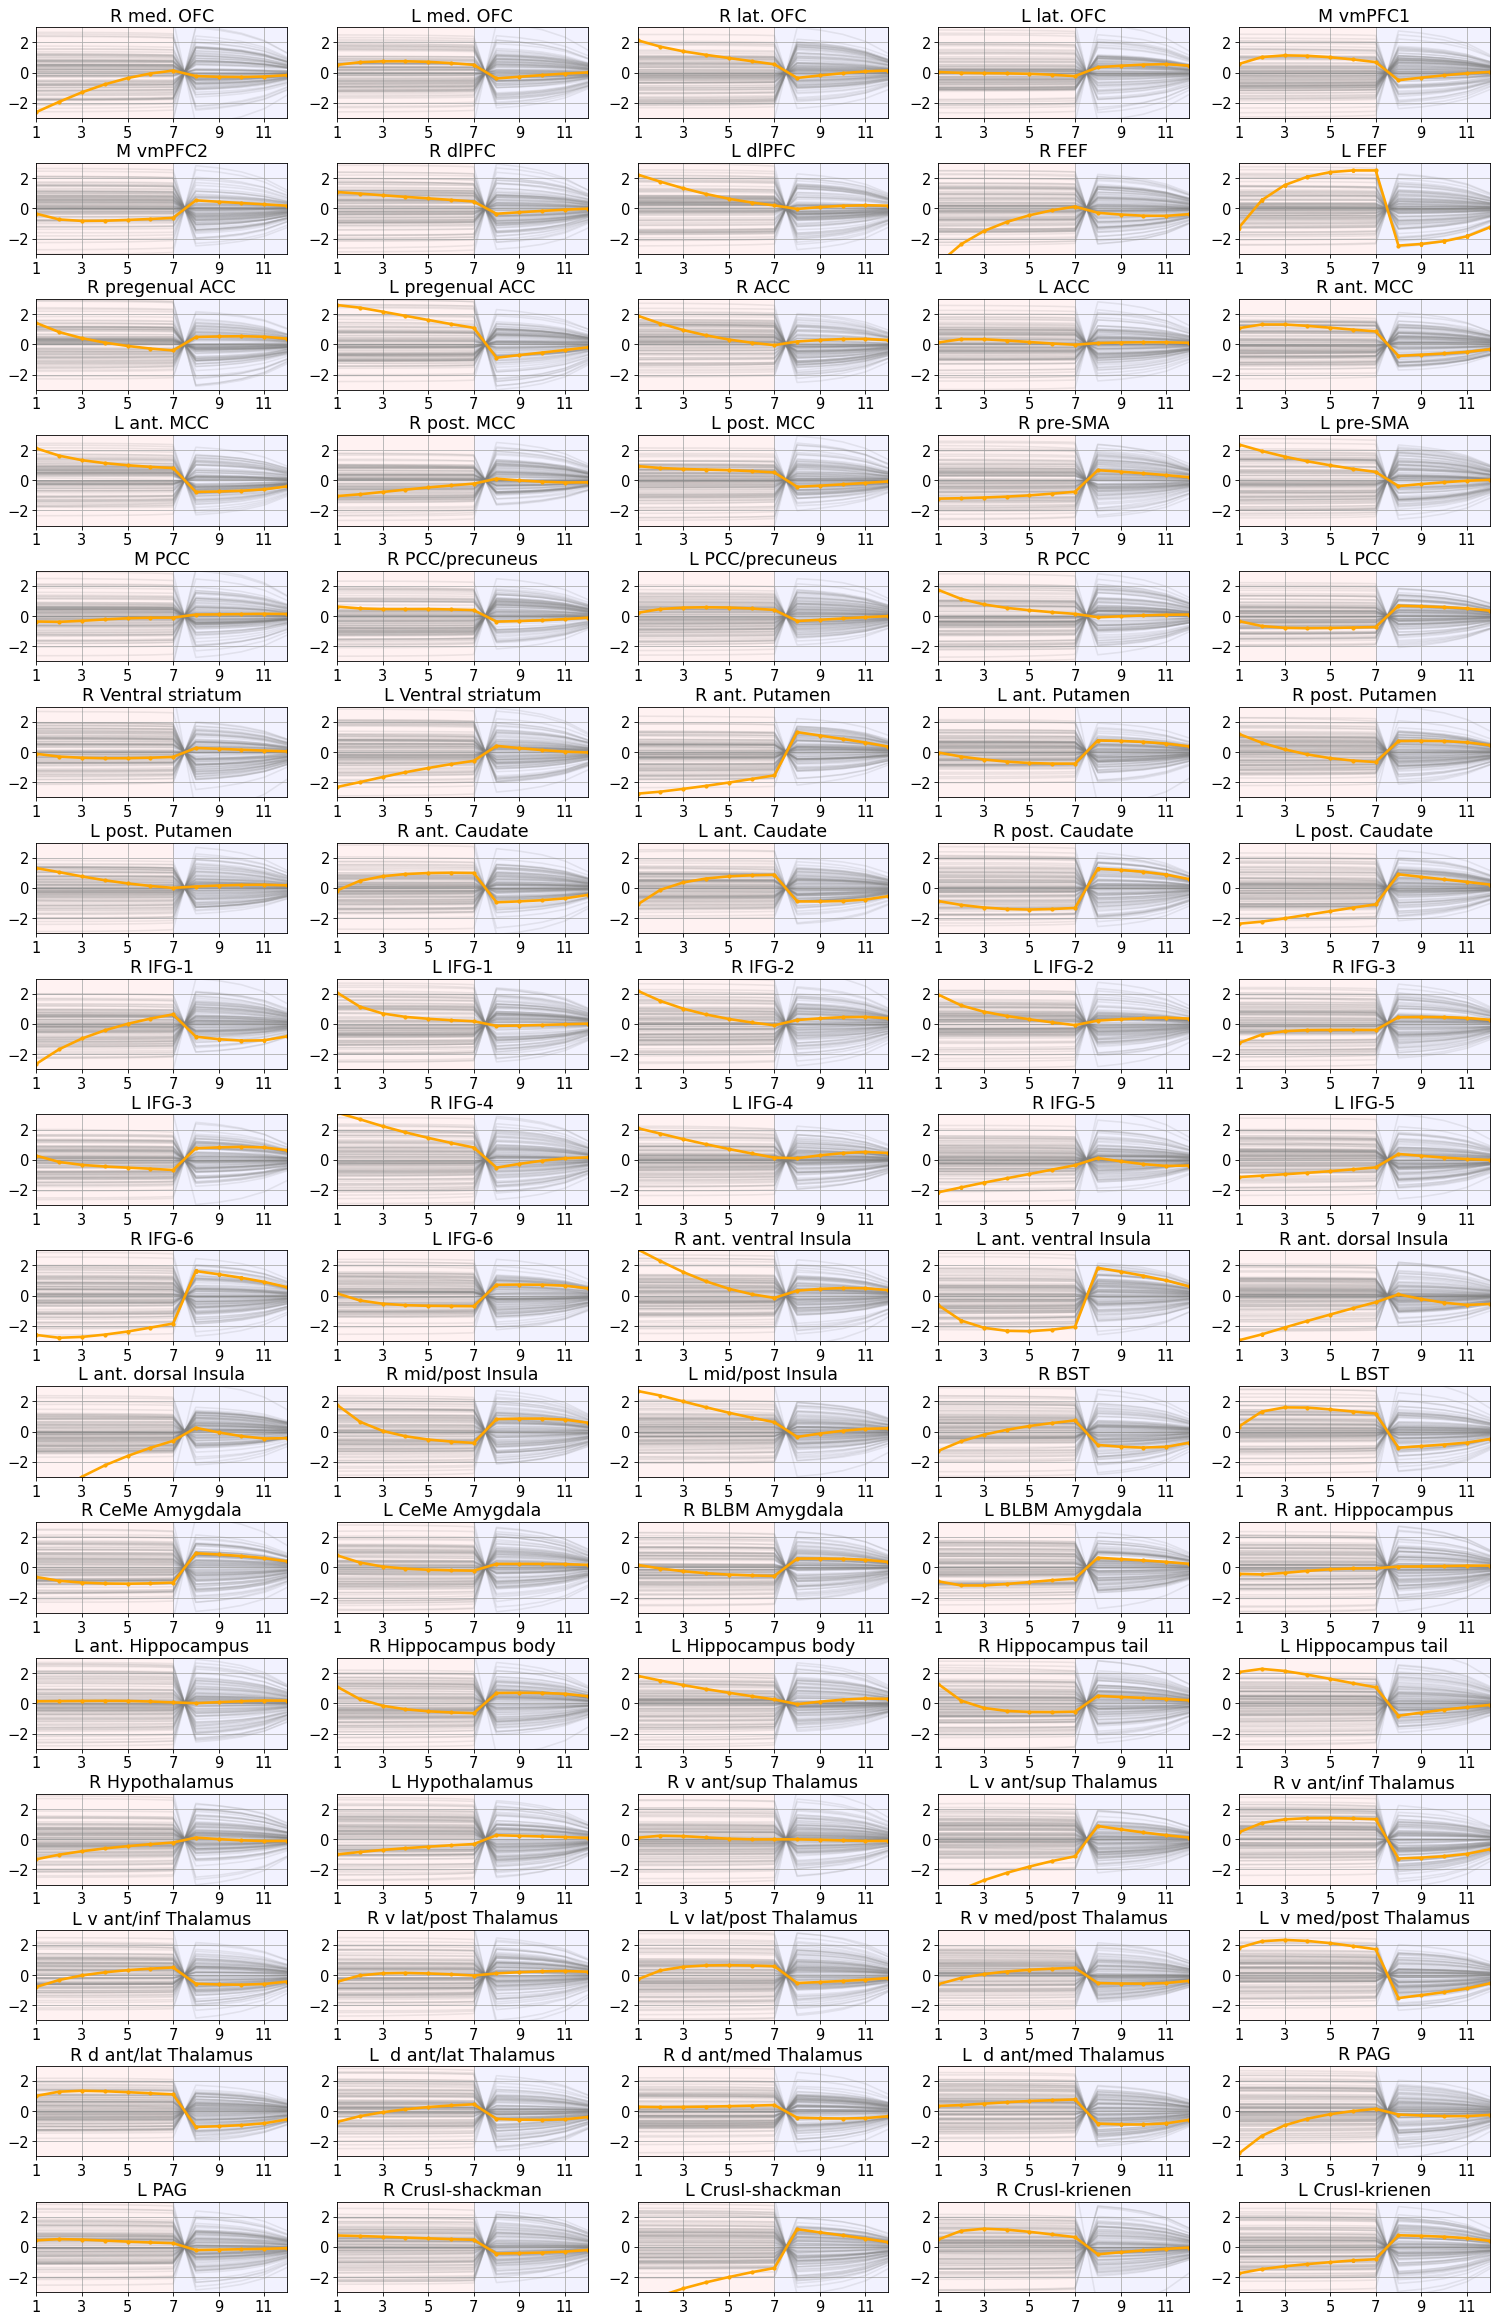

In [49]:
roi_names_file = f"/home/govindas/parcellations/templates/README_MAX_ROIs_final_gm_85.txt"
roi_names = pd.read_csv(roi_names_file, delimiter='\t')

sal_appr = saliency_df['saliency_appr']
sal_retr = saliency_df['saliency_retr']

cm = 1 #1/2.54
nrows, ncols = 17, 5 # 17 x 5 = 85 = num_rois
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols, 
                        figsize=(25*cm, 40*cm), 
                        sharex=False,
                        sharey=False,
                        dpi=75)

plt.subplots_adjust(left=None, bottom=None, 
                    right=None, top=None, 
                    wspace=None, hspace=0.5)

x_pts = np.linspace(1, num_time, num_time)
y_pts = np.linspace(-3, 3, 7)

for idx_roi in np.arange(len(roi_names)):
    ax = axs[idx_roi//ncols, np.mod(idx_roi, ncols)]
    ax.set_title(f"{' '.join(roi_names.iloc[idx_roi][['Hemi', 'ROI']].values)}")

    y_alt_pts = np.concatenate([sal_appr[-1, :appr_TR, idx_roi], sal_retr[-1, appr_TR:, idx_roi]])
    y_null_pts = np.concatenate([sal_appr[:-1, :appr_TR, idx_roi], sal_retr[:-1, appr_TR:, idx_roi]], axis=1)
    yerr = np.concatenate([alt_sal_appr_std[:appr_TR, idx_roi], alt_sal_retr_std[appr_TR:, idx_roi]])
    ax.errorbar(
        x_pts, 
        y_alt_pts, 
        yerr=yerr,
        color='orange', marker='.', linewidth=2.5,
        linestyle='-', label='Alt.')
    ax.plot(
        x_pts, 
        y_null_pts.T, 
        color='grey', marker='', alpha=0.15,
        linestyle='-', label='Null')

    ax.fill_betweenx(y_pts, x_pts[0], x_pts[6], color='red', alpha=0.05)
    ax.fill_betweenx(y_pts, x_pts[6], x_pts[-1], color='blue', alpha=0.05)

    # layout
    ax.set_xticks(x_pts[::2])
    ax.set_xlim(x_pts[0], x_pts[-1])
    ax.set_ylim(y_pts[0], y_pts[-1])
    ax.grid(True)
    # ax.legend()